# keras vgg16

In [1]:
#####
from tensorflow.keras import layers, models
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
tf.random.set_seed(0)

#### 학습데이터 불러오기

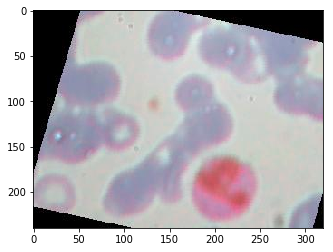

In [2]:
##############################################################################
###                          train data                                    ###
##############################################################################
TRAIN_DATADIR = 'C:/Users/jaebyung.lee/Desktop/Python/cellimage/TRAIN'
CATEGORIES = ['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']


### training data plt
for category in CATEGORIES:
    path = os.path.join(TRAIN_DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
        plt.imshow(img_array)
        plt.show()
        break
    break


################ create training data#########################################
training_data = []
IMG_SIZE = 224
CHANNEL = 3
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(TRAIN_DATADIR, category) #path
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass
create_training_data()
len(training_data)

import random
random.shuffle(training_data)
###############################################################################
TRAIN_X = []
TRAIN_y = []

for features, label in training_data:
    TRAIN_X.append(features)
    TRAIN_y.append(label)    

TRAIN_X = np.array(TRAIN_X).reshape(-1, IMG_SIZE, IMG_SIZE ,CHANNEL)
TRAIN_y = np.array(TRAIN_y)
##############################################################################

#### 검증 데이터 불러오기

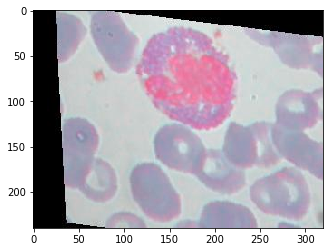

In [3]:
##############################################################################
###                          valid data                                    ###
##############################################################################
VALID_DATADIR = 'C:/Users/jaebyung.lee/Desktop/Python/cellimage/VALID'
CATEGORIES = ['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']


### training data plt
for category in CATEGORIES:
    path = os.path.join(VALID_DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
        plt.imshow(img_array)
        plt.show()
        break
    break


################ create training data#########################################
valid_data = []

def create_valid_data():
    for category in CATEGORIES:
        path = os.path.join(VALID_DATADIR, category) #path
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                valid_data.append([new_array, class_num])
            except Exception as e:
                pass
create_valid_data()
len(valid_data)
random.shuffle(valid_data)
###############################################################################
VALID_X = []
VALID_y = []

for features, label in valid_data:
    VALID_X.append(features)
    VALID_y.append(label)    

VALID_X = np.array(VALID_X).reshape(-1, IMG_SIZE, IMG_SIZE ,CHANNEL)
VALID_y = np.array(VALID_y)
##############################################################################

#### 데이터 변환

In [4]:
# Convert from uint8 to float32 and
# normalize images value from [0, 255] to [0, 1].
x_train = tf.convert_to_tensor(TRAIN_X, dtype=tf.float32) / 255.
x_valid = tf.convert_to_tensor(VALID_X, dtype=tf.float32) / 255.
#x_test = tf.convert_to_tensor(TEST_X, dtype=tf.float32) / 255.

print(x_train[0].shape)
print(x_valid[0].shape)

(224, 224, 3)
(224, 224, 3)


#### keras vgg16

In [5]:
##############################################################################
###                             VGG16                                      ###
#########################################################################
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Dropout, Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

#vgg16 model
vgg16_model = tensorflow.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))


# let’s disable training on all but the last 4 layers of the pretrained model.
for layer in vgg16_model.layers[:-4]:
    layer.trainable = False


# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg16_model)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2

#### 학습 및 평가

In [8]:
# Parameters for Training
learning_rate = 0.0001
batch_size = 16
training_steps = 40


# Stochastic gradient descent optimizer.
optimizer = Adam(lr=learning_rate)

# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, TRAIN_y))
training_batch = train_data.batch(batch_size).repeat(training_steps)



model.compile(optimizer= optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# training phase
model.fit(x_train, TRAIN_y,
           validation_data=(x_valid, VALID_y),
           batch_size= batch_size, 
           epochs=training_steps)

Train on 426 samples, validate on 214 samples
Epoch 1/40
426/426 [==============================] - 6s 13ms/sample - loss: 1.0727 - accuracy: 0.5423 - val_loss: 1.1654 - val_accuracy: 0.4159
Epoch 2/40
426/426 [==============================] - 5s 12ms/sample - loss: 0.9252 - accuracy: 0.5962 - val_loss: 0.9487 - val_accuracy: 0.5794
Epoch 3/40
426/426 [==============================] - 5s 12ms/sample - loss: 0.8341 - accuracy: 0.6362 - val_loss: 0.7808 - val_accuracy: 0.6963
Epoch 4/40
426/426 [==============================] - 5s 12ms/sample - loss: 0.7244 - accuracy: 0.7066 - val_loss: 0.7144 - val_accuracy: 0.7103
Epoch 5/40
426/426 [==============================] - 5s 12ms/sample - loss: 0.5435 - accuracy: 0.8146 - val_loss: 0.9127 - val_accuracy: 0.6682
Epoch 6/40
426/426 [==============================] - 5s 12ms/sample - loss: 0.5015 - accuracy: 0.8099 - val_loss: 0.6371 - val_accuracy: 0.7991
Epoch 7/40
426/426 [==============================] - 5s 12ms/sample - loss: 0.2960 